In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from scipy.stats import norm
from itertools import combinations, permutations, product

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207881 entries, 0 to 207880
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        207881 non-null  object
 1   date      207881 non-null  object
 2   title     207881 non-null  object
 3   body      207881 non-null  object
 4   subjects  207881 non-null  object
 5   category  207881 non-null  object
dtypes: object(6)
memory usage: 11.1+ MB


In [4]:
df['category'].unique()

array(['autot', 'musiikki', 'luonto', 'vaalit', 'taudit', 'työllisyys',
       'jääkiekko', 'kulttuuri', 'rikokset', 'koulut', 'tulipalot',
       'ruoat'], dtype=object)

In [5]:
# df.drop_duplicates('id', inplace=True)

In [6]:
# df.reset_index(inplace=True, drop=True)

In [7]:
# df.to_json('data/dev/cluster_12_cats.json')

In [2]:
def sample_sigmoid(time_range, n=1, change_rate=0.5):
    x = np.arange(time_range)
    mid = int(time_range / 2)
    y = (1 / (1 + np.exp(-0.1* (x-mid) ))) * n * change_rate
    y = (y - y.min()) / (y.max() - y.min())
    
    y = n + y * n * change_rate
    
    print(y)
    plt.figure(figsize=(20, 5))
    plt.plot(x, y)
    plt.show()
    
def sample_bell(time_range, n=1, change_rate=0.5, std=0):
    x = np.arange(time_range)
    mu = int(time_range / 2)
    std = std if std else int(time_range / 5)
    y = norm.pdf(x, mu, std)
    # scale 0-1
    y_min = y.min()
    y_max = y.max()
    y = (y - y_min) / (y_max - y_min)
    # add n docs
    y = n + y * n * change_rate
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.show()
    

def sample_linear(time_range, n=100, change_rate=0.5):
    x = np.arange(time_range)
    y = (x - x.min()) / (x.max() - x.min())
    y = n + y * n * change_rate
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.show()

[1.         1.00434886 1.00907571 1.01420522 1.01976211 1.02577071
 1.03225463 1.03923621 1.04673601 1.05477219 1.06335984 1.07251035
 1.08223063 1.09252244 1.10338175 1.11479806 1.12675395 1.13922469
 1.15217803 1.16557416 1.17936597 1.19349947 1.20791447 1.22254552
 1.237323   1.25217443 1.26702586 1.28180334 1.29643439 1.31084939
 1.32498289 1.3387747  1.35217083 1.36512417 1.37759491 1.38955081
 1.40096711 1.41182642 1.42211823 1.43183851 1.44098902 1.44957668
 1.45761285 1.46511265 1.47209423 1.47857815 1.48458676 1.49014364
 1.49527315 1.5       ]


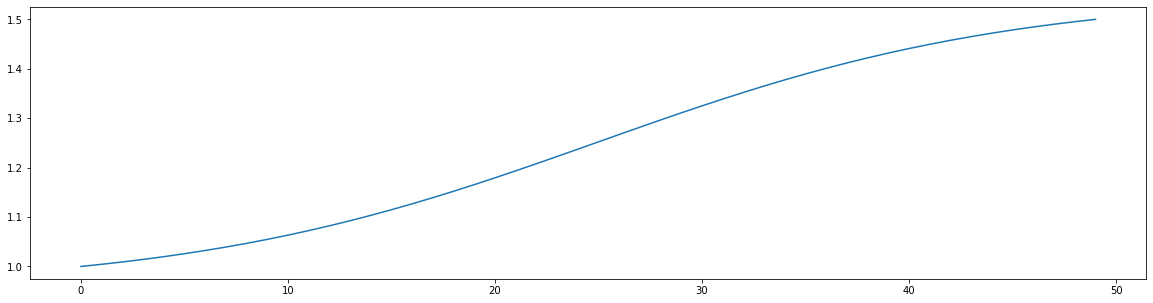

In [3]:
sample_sigmoid(50, n=1, change_rate=0.5)

In [3]:
def linear_pattern(n=1, start=0, stop=100, change_rate=1):
    """
    Sampling up pattern, start and end in random points
    """
    # print(lower_p, upper_p)
    # change_points = np.array([0, lower_p, upper_p, timeline], dtype=int)
    x = np.arange(start, stop)
    # normalize x to range 0-1
    y = (x - start) / (stop - start)
    freq_rates = n + y * n * change_rate
    
    return freq_rates

def sigmoid_pattern(n=1, start=0, stop=100, change_rate=1):
    x = np.arange(start, stop)
    mid = int((stop - start) / 2)
    y = 1 / (1 + np.exp(-0.1* (x-mid) ))
    y = (y - y.min()) / (y.max() - y.min())
    
    freq_rates = n + y * n * change_rate
    return freq_rates

def flat_pattern(n=1, start=0, stop=100):
    freq_rates = np.ones(stop-start) * n
    return freq_rates


def bell_pattern(n=1, start=0, stop=100, change_rate=1, std=0):
    sample_list = []
    time_range = stop - start
    
    x = np.arange(start, stop)
    mu = int(time_range / 2)
    
    std = std if std else int(time_range / 5)
    y = norm.pdf(np.arange(time_range), mu, std)
    # scale 0-1
    y = (y - y.min()) / (y.max() - y.min())
    # add n docs
    freq_rates = n + y * n * change_rate
    
    return freq_rates             


def sample_pattern(pattern, timeline=100, change_rate=0.01):
    sample = None
    
    if pattern == 'up':
        lower_p = np.random.randint(low=1, high=timeline-30)
        upper_p = np.random.randint(low=lower_p+20, high=timeline)
        
        # f1, f2, f3 [-1] is the start of freqs ratio for the pattern as the chaning variable
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = sigmoid_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'down':
        lower_p = np.random.randint(low=1, high=timeline-30)
        upper_p = np.random.randint(low=lower_p+20, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = sigmoid_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=-change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'spike_up':
        n_point = np.random.randint(1, 5)
        invalid = True
        
        while invalid:
            change_points = np.sort(np.random.choice(range(5, timeline - 5), n_point, replace=False))
            diff = np.diff(change_points)
            invalid = len(np.where(diff < 10)[0])
            
        change_rates = np.random.uniform(0.3, change_rate, n_point)
        #print(change_points)
        cur_p = 0
        cur_n = 1
        
        time_freqs = []
        
        for i, p in enumerate(change_points):
            #print(cur_p, p - 2)
            f1 = flat_pattern(cur_n, start=cur_p, stop=p-2)
            cur_n = f1[-1]
            f2 = bell_pattern(cur_n, start=p-2, stop=p+3, change_rate=change_rates[i], std=0.1)
            cur_n = f2[-1]
            
            time_freqs.append(f1)
            time_freqs.append(f2)
            
            cur_p = p + 3
            
            if i == len(change_points) - 1:
                f3 = flat_pattern(cur_n, start=cur_p, stop=timeline)
                time_freqs.append(f3)

        time_freqs = np.concatenate(time_freqs)
        time_freqs = time_freqs / time_freqs.sum()
        
    elif pattern == 'spike_down':
        n_point = np.random.randint(1, 5)
        invalid = True
        # generate n points with min distance 10
        while invalid:
            change_points = np.sort(np.random.choice(range(5, timeline - 5), n_point, replace=False))
            diff = np.diff(change_points)
            invalid = len(np.where(diff < 10)[0])
            
        change_rates = np.random.uniform(0.3, change_rate, n_point)
        cur_p = 0
        cur_n = 1
        
        time_freqs = []
        
        for i, p in enumerate(change_points):

            f1 = flat_pattern(cur_n, start=cur_p, stop=p-2)
            cur_n = f1[-1]
            f2 = bell_pattern(cur_n, start=p-2, stop=p+3, change_rate=-change_rates[i], std=0.1)
            cur_n = f2[-1]
            
            time_freqs.append(f1)
            time_freqs.append(f2)
            
            cur_p = p + 3
            
            if i == len(change_points) - 1:
                f3 = flat_pattern(cur_n, start=cur_p, stop=timeline)
                time_freqs.append(f3)
            
        time_freqs = np.concatenate(time_freqs)
        time_freqs = time_freqs / time_freqs.sum()
        
    elif pattern == 'up_down':
        lower_p = np.random.randint(low=1, high=timeline-20)
        upper_p = np.random.randint(low=lower_p+10, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = bell_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()
        
        mid_p = int(lower_p + (upper_p - lower_p) / 2)
        change_points = np.array([lower_p, mid_p, upper_p])
        
    elif pattern == 'down_up':
        lower_p = np.random.randint(low=1, high=timeline-20)
        upper_p = np.random.randint(low=lower_p+10, high=timeline)
        
        f1 = flat_pattern(1, start=0, stop=lower_p)
        f2 = bell_pattern(f1[-1], start=lower_p, stop=upper_p, change_rate=-change_rate)
        f3 = flat_pattern(f2[-1], start=upper_p, stop=timeline)
        
        # the frequency ratio 
        
        time_freqs = np.concatenate((f1, f2, f3))
        time_freqs = time_freqs / time_freqs.sum()

        mid_p = int(lower_p + (upper_p - lower_p) / 2)
        change_points = np.array([lower_p, mid_p, upper_p])
        
    else:
        time_freqs = flat_pattern(1, start=0, stop=timeline)
        time_freqs = time_freqs / time_freqs.sum()
        change_points = np.empty(shape=(0,))
        
    return time_freqs, change_points.astype(int)

def sample_val_pattern(data, time_freqs, change_points, n_doc):
    # calculate the docs_num based on the total docs and its freqs distribution
    docs_num = (n_doc * time_freqs).astype(int)
    sample = data.sample(n_doc)
    sample['time'] = -1
        
    cur = 0
    for i, n in enumerate(docs_num):
        sample.iloc[cur:cur+n, sample.columns.get_loc("time")] = i
        cur += n
    
    # because the freq is converted to int so some articles will remain -1 for time, we need to prunt those
    sample = sample[sample['time'] > -1]
    
    return sample, change_points


def create_train_samples(timeline=100, n_samples=100, noise_rates=[0, 0.01, 0.1], change_rates=[0.5, 1]):
    patterns = ['up', 'down', 'up_down', 'down_up', 'spike_up', 'spike_down', 'stable']
    events = np.random.choice(patterns, n_samples, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4])
    
    data = []
    
    for e in events:
        change_rate = np.random.uniform(*change_rates)
        values, pivots = sample_pattern(e, timeline=100, change_rate=change_rate)
        values = values + np.random.uniform(0, 1, size=timeline) * np.random.choice(noise_rates)
        values = minmax_scale(values)
        data.append([values, pivots, e])
    
    df = pd.DataFrame(data, columns=['freqs','pivots', 'pattern'])
    
    return df
    
    


def create_val_samples(df, timeline=100, n_samples=100, min_doc=50, max_doc=100, frac=0.99, change_rate=0.5):
    categories = df['category'].unique()
    
    samples = []   # list article ids
    tracker = pd.DataFrame(columns=['category', 'event', 'pivots'])
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    patterns = ['up', 'down', 'up_down', 'down_up', 'spike_up', 'spike_down', 'noise']
    # patterns = ['spike_down']
    
    g = df.groupby(['category'])
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
        event = np.random.choice(patterns)
        
        df_cat = g.get_group(cat)
        df_len = len(df_cat)
        n_doc = np.random.randint(min_doc, max_doc)
        n_doc = min(n_doc, df_len)
        
        df_sample, points = sample_pattern(event, df_cat[['id', 'category']], n_doc, change_rate=change_rate)
        tracker = tracker.append({'category':cat, 'event': event, 'pivots': points}, ignore_index=True)
        
        df_sample = df_sample.sample(frac=frac)
        df_sample.reset_index(drop=True, inplace=True)
        samples.append(df_sample)
        
    return samples, tracker


def create_dataset2(df, timeline=100, change_rate=2, n_samples=100, min_doc=50, max_doc=100, frac=0.98):
    categories = df['category'].unique()
    n_cat = len(categories)
    
    samples = []   # list article ids
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
#         df_target = df[df['category'] == cat]
#         df_noise = df[~(df['category'] == cat)]
        
        # take random n articles from group 1 and 2
        # y = x * 1.2
        
        df_sample = pd.DataFrame()
        
        for c, g in df.groupby(['category']):
            time_unit = []
            n_doc = np.random.randint(min_doc, max_doc)
    
            for i in range(timeline):
                if c == cat:
                    n_target = int(n_doc  * (1 + i * change_rate/timeline))
                    sample = g[['id', 'category']].sample(n=n_target)
                    sample['target'] = True
                else:
                    n_noise = int(n_doc * (2 + change_rate)/2)
                    sample = g[['id', 'category']].sample(n=n_noise)
                    sample['target'] = False

                sample['time'] = i
                time_unit.append(sample)
                
            df_sample = pd.concat((df_sample, *time_unit), ignore_index=True)
        
        df_sample = df_sample.sample(frac=frac)
        # sample.reset_index(drop=True, inplace=True)
        samples.append(df_sample)
        
    return samples

In [32]:
samples = create_train_samples(timeline=100, n_samples=100000, noise_rates=[1e-4, 1e-3, 0.005], change_rates=[0.5, 0.8])

In [78]:
samples.head()

,values,pivots,pattern
0,"[0.5056686584907766, 0.5412371616451566, 0.464...",[],stable
1,"[0.11856081665833074, 0.15031130297001027, 0.4...",[],stable
2,"[0.08225151311431222, 0.07012277081319107, 0.0...","[58, 93]",up
3,"[0.9999515941577919, 0.9933137999450423, 0.992...","[52, 98]",down
4,"[0.015360490648803182, 0.0, 0.0007598629177587...","[13, 26, 60, 87]",spike_up


In [33]:
samples.to_pickle('data/prod/train_samples.pkl')

In [7]:
%%time
samples, tracker = create_samples(df, timeline=100, n_samples=2000, min_doc=5000, max_doc=15000, change_rate=0.8)

CPU times: user 57.5 s, sys: 265 ms, total: 57.8 s
Wall time: 57.5 s


In [8]:
tracker.head()

,category,event,pivots
0,rikokset,up,"[48, 85]"
1,jääkiekko,spike_down,"[11, 38, 54]"
2,kulttuuri,spike_down,[55]
3,vaalit,up_down,"[18, 35, 53]"
4,koulut,up,"[28, 94]"


In [7]:
def visualize_sample(df):
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    g = df.groupby(['time'])['id'].count()
    ax.plot(g.index, g.values)
    
    ax.set(xlabel='time', ylabel='Numbers')
    # ax.legend()
    ax.grid()
    ax.set_ylim(0, 200)
    plt.show()
    

def visualize_samples(ids, samples):
    fig, ax = plt.subplots(figsize=(20, 10))
    labels = ['Down', 'Down Up', 'Stable', 'Spike Up',  'Up',  'Up Down', 'Spike Down']
    
    distance = [0, 100, 170, 200, 300, 360, 420]
    
    for i, idx in enumerate(ids):
        df = samples[idx]
        g = df.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values + distance[i], label=labels[i])
        # distance += 100
    
    ax.set(xlabel='Time')
    ax.legend(fontsize=12)
    ax.grid()
    ax.get_yaxis().set_visible(False)
    # ax.set_ylim([0, 200])
    plt.show()
    
def visualize_train_sample(df):
    idx = np.random.randint(len(df))
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    indexes = range(100)
    #g = df.groupby(['time'])['id'].count()
    print('pattern', df.iloc[idx]['pattern'])
    ax.plot(indexes, df.iloc[idx]['freqs'])
    
    ax.set(xlabel='time', ylabel='Numbers')
    # ax.legend()
    ax.grid()
    ax.set_ylim(0, 1.1)
    plt.show()

pattern stable


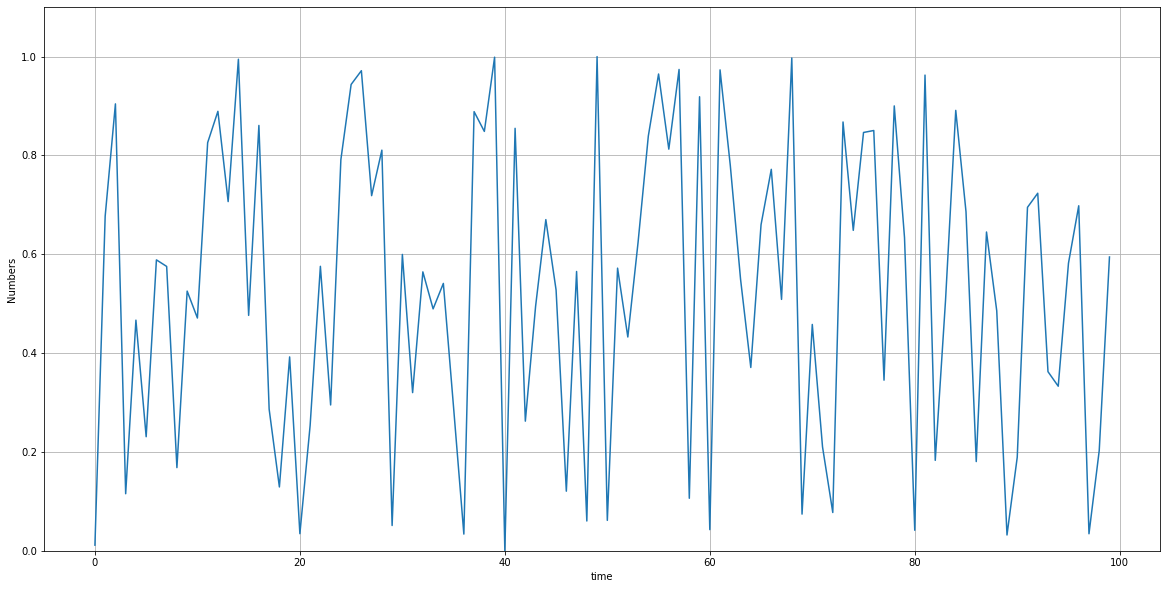

In [31]:
visualize_train_sample(samples)

In [43]:
# visualize_samples([1598, 1238, 736, 65, 55, 1693, 895], samples)

category      vaalit
event             up
pivots      [19, 95]
Name: 1528, dtype: object


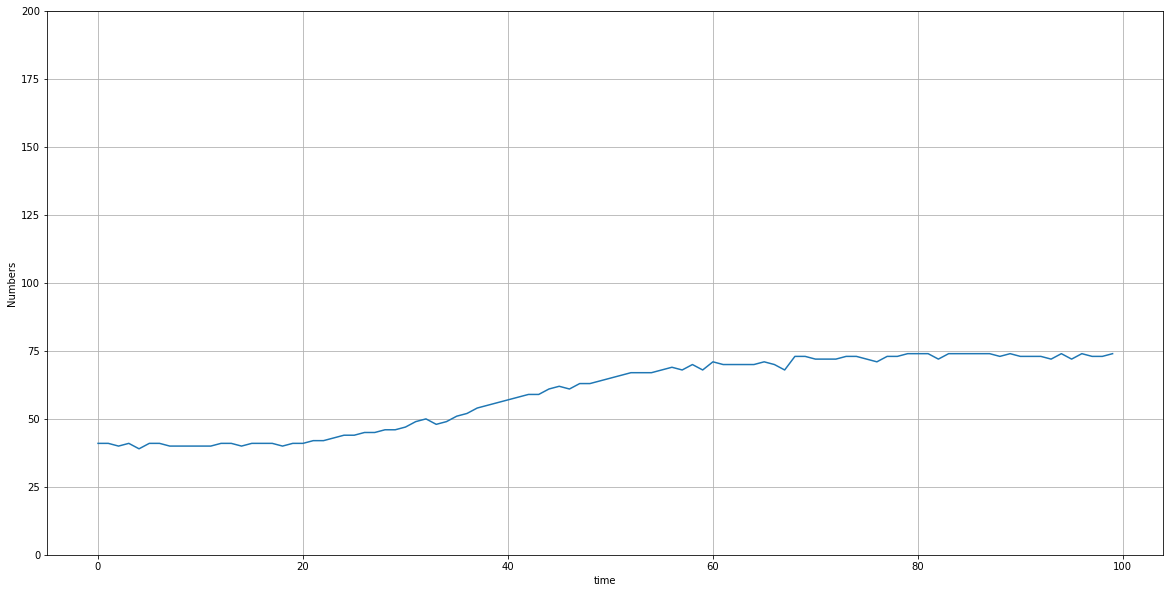

In [23]:
randid = np.random.randint(2000)
#print(tracker.iloc[randid])
visualize_sample(samples[randid])
# print(tracker.iloc[0])

# noise 736, periodic 65, up 462 (1431), down 1598, up down 1693, down up 1238, complex 895

In [24]:
pickle.dump(samples, open("data/prod/sample_7_patterns_2.pkl", "wb"))
tracker.to_pickle('data/prod/tracker_7_patterns_2.pkl')

In [4]:
samples = pickle.load(open("data/prod/sample_7_patterns.pkl", "rb"))
tracker = pd.read_pickle('data/prod/tracker_7_patterns.pkl')

In [5]:
tracker.head()

,category,event,pivots
0,luonto,up_down,"[5, 86]"
1,työllisyys,noise,[]
2,taudit,up_down,"[7, 95]"
3,työllisyys,up,"[23, 82]"
4,ruoat,down,"[25, 96]"


In [25]:
def create_cluster_data(samples, tracker, n=10, n_event=1):
    df_noise = tracker[tracker['event'] == 'noise']
    df_change = tracker[tracker['event'] != 'noise']
    
    data = []
    # generate n cluster for each samples, from 6 to 12, with prob for 12 is most
    # n_clusters = np.random.choice(range(6, 13), size=n, p=[0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2])
    track_ids = []
    
    for i in range(n):
        df_data = []
        unique_cats = []
        n_cluster = 12 # n_clusters[i]
        
        # select one event for target
        while len(unique_cats) < n_event:
            target = df_change[~df_change['category'].isin(unique_cats)].sample(1).iloc[0]
            
#             if target['category'] in unique_cats:
#                 continue
#             else:
            sample = samples[target.name]
            sample['event'] = target['event']
            unique_cats.append(target['category'])
            df_data.append(sample)
            track_ids.append(target.name)
        
        while len(unique_cats) < n_cluster:
            # print(unique_cats)
            noise = df_noise[~df_noise['category'].isin(unique_cats)].sample(1).iloc[0]
            # print(noise)
            
#             if noise['category'] in unique_cats:
#                 continue
#             else:
            sample = samples[noise.name]
            sample['event'] = noise['event']
            unique_cats.append(noise['category'])
            df_data.append(sample)
            
        df_data = pd.concat(df_data, ignore_index=True)
        data.append(df_data)
        
    df_pivots = tracker.iloc[track_ids]
    
    return data, df_pivots


In [26]:
%%time
dataset, pivots = create_cluster_data(samples, tracker, n=2000, n_event=1)

CPU times: user 48.5 s, sys: 2.32 s, total: 50.8 s
Wall time: 50.9 s


In [27]:
randid = np.random.randint(2000)
dataset[randid].head()

,id,category,time,event
0,3-6438589,vaalit,42,down
1,3-7917304,vaalit,21,down
2,3-9577710,vaalit,27,down
3,3-9300247,vaalit,71,down
4,3-10045459,vaalit,84,down


In [152]:
pivots.iloc[randid]

category    musiikki
event             up
pivots      [26, 90]
Name: 396, dtype: object

In [28]:
pickle.dump(dataset, open("data/prod/dataset_1_event_2.pkl", "wb"))

In [29]:
pivots.to_pickle('data/prod/dataset_1_pivot_2.pkl')

In [2]:
dataset = pickle.load(open("data/dev/dataset_1_event.pkl", "rb"))

In [472]:
def save_dataset_folder(dataset):
    for i, df in enumerate(dataset):
        df.to_json('data/dev/samples/sample_' + str(i) + '.json')

In [473]:
%%time
save_dataset_folder(dataset)

CPU times: user 2min 8s, sys: 5.86 s, total: 2min 14s
Wall time: 2min 15s


In [17]:
rand_id = np.random.randint(10)
df_sample = dataset[rand_id]

In [18]:
df_sample.head()

,id,category,time,event
0,3-5420741,rikokset,0,down
1,3-9680082,rikokset,0,down
2,3-6758211,rikokset,0,down
3,3-9194366,rikokset,0,down
4,3-8725027,rikokset,0,down


In [19]:
def get_sample_text(df_text, sample_ids):
    df = df_text.reset_index(drop=True)
    df = df.set_index('id')

    df_sample = df.loc[sample_ids]
    
    return df_sample

In [20]:
df_sample_text = get_sample_text(df, df_sample['id'])

In [21]:
df_sample_text.head()

,date,title,body,subjects,category
id,,,,,
3-5420741,2011-09-09T17:04:26+0300,Seksityöaktivistit vastustavat seksin oston tä...,Helsinkiin kokoontuneet pohjoismaiset seksity...,"[kotimaan uutiset, prostituutio, seksin ostami...",rikokset
3-9680082,2017-06-20T07:03:51+0300,Hallitus kiistää vakoilun,Vakoiluviestejä on lähetetty niin laajamittai...,"[meksiko, vakoiluohjelma, ulkomaat, tiedustelu...",rikokset
3-6758211,2013-08-01T11:12:32+0300,KHO kumosi Viestintäviraston päätöksen Itellan...,"Korkein hallinto-oikeus katsoi, että Viestint...","[kotimaan uutiset, posti group oyj, viestintäv...",rikokset
3-9194366,2016-09-27T14:48:01+0300,Kolme kertaa kaivinkoneen päälle,Pyhäjoen ydinvoimala-alueen työkoneiden pääl...,"[rikos (tv-sarja), fennovoima, aktivismi, rang...",rikokset
3-8725027,2016-03-07T16:45:59+0200,Poliisi: Yhteys Veikoon vain lehdistön kautta,Salaperäisen virolaisen Veikon väitteet Helsi...,"[kotimaan uutiset, jari aarnio, huumepoliisi, ...",rikokset


In [22]:
df_sample[df_sample['event'] == 'noise'].category.unique()

array(['autot', 'tulipalot', 'työllisyys', 'musiikki'], dtype=object)

In [23]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32521 entries, 0 to 32520
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32521 non-null  object
 1   category  32521 non-null  object
 2   time      32521 non-null  int64 
 3   event     32521 non-null  object
dtypes: int64(1), object(3)
memory usage: 1016.4+ KB


In [3]:
def visualize_trending(df):
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    n_group = df.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in n_group:
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

In [5]:
# visualize_trending(df_sample)

In [2]:
### try to match dataset with the tracker

In [3]:
dataset = pickle.load(open("data/dev/dataset_1_event.pkl", "rb"))

In [6]:
tracker = pd.read_pickle('data/dev/tracker_7_patterns.pkl')

In [7]:
samples = pickle.load(open("data/dev/sample_7_patterns.pkl", "rb"))

In [6]:
dataset[0].head()

,id,category,time,event
0,3-5315164,tulipalot,44,periodic
1,3-8718277,tulipalot,84,periodic
2,3-6495998,tulipalot,68,periodic
3,3-8927863,tulipalot,39,periodic
4,3-5062412,tulipalot,10,periodic


In [7]:
samples[0].head()

,id,category,time
0,3-5067773,vaalit,38
1,3-6356605,vaalit,73
2,3-6298727,vaalit,57
3,3-9557392,vaalit,79
4,3-9254950,vaalit,97


In [8]:
sample = dataset[0]

In [19]:
sample['id'].values

array(['3-5315164', '3-8718277', '3-6495998', ..., '3-5056491',
       '3-6810889', '20-157926'], dtype=object)

In [14]:
tracker.head()

,category,event,pivots
0,vaalit,noise,[]
1,jääkiekko,down_up,"[11, 41, 72]"
2,tulipalot,complex,"[20, 40, 70]"
3,vaalit,noise,[]
4,rikokset,up,"[26, 96]"


In [15]:
tracker.category.unique()

array(['vaalit', 'jääkiekko', 'tulipalot', 'rikokset', 'musiikki',
       'taudit', 'kulttuuri', 'koulut', 'autot', 'työllisyys', 'ruoat',
       'luonto'], dtype=object)

In [12]:
def get_cat_event(df):
    target = df[df['event'] != 'noise'].iloc[0]
    cat = target['category']
    event = target['event']
    return cat, event

In [13]:
get_cat_event(sample)

('tulipalot', 'periodic')

In [22]:
def match_tracker(df, samples, tracker):
    cat, event = get_cat_event(df)
    target_ids = df[df['event'] != 'noise']['id'].values
    
    # get all id from tracker which have cat and event
    df_track = tracker[(tracker['category'] == cat) & (tracker['event'] == event)]
    track_ids = df_track.index.values
    
    match_id = None
    
    # now for each sample event, try to get list id
    for i in track_ids:
        sample = samples[i]
        sample_ids = sample['id'].values
        if np.array_equal(sample_ids, target_ids):
            match_id = i
            break
    
    return match_id

In [23]:
match_id = match_tracker(sample, samples, tracker)

In [24]:
match_id

1459

In [25]:
tracker.iloc[match_id]

category                   tulipalot
event                       periodic
pivots      [10, 26, 42, 58, 74, 90]
Name: 1459, dtype: object

In [31]:
def match_all(dataset, samples, tracker):
    match_ids = []
    
    for df in tqdm(dataset):
        match_id = match_tracker(df, samples, tracker)
        match_ids.append(match_id)
        
    return match_ids

In [32]:
match_ids = match_all(dataset, samples, tracker)

100%|██████████| 2000/2000 [00:26<00:00, 74.76it/s]


In [33]:
len(match_ids)

2000

In [34]:
match_ids[10]

1995

In [68]:
def test_match(match_ids, dataset, tracker):
    test_id = np.random.randint(2000)
    match_id = match_ids[test_id]
    
    sample = dataset[test_id]
    cat, event = get_cat_event(sample)
    
    track = tracker.iloc[match_id]
    
    if track['category'] == cat and track['event'] == event:
        return True
    else:
        print(track['category'], cat)
        print(track['event'], event)
        
        return False
    
    

In [119]:
test_match(match_ids, dataset, tracker)

True

In [120]:
df_match = tracker.iloc[match_ids]

In [124]:
df_match.head()

,category,event,pivots
0,tulipalot,periodic,"[10, 26, 42, 58, 74, 90]"
1,työllisyys,complex,"[30, 60, 90]"
2,musiikki,down,"[6, 90]"
3,rikokset,down_up,"[30, 54, 78]"
4,koulut,up_down,"[1, 39, 77]"


In [122]:
dataset[3].head()

,id,category,time,event
0,3-7617150,rikokset,35,down_up
1,3-5347603,rikokset,86,down_up
2,3-6607317,rikokset,50,down_up
3,3-6778959,rikokset,72,down_up
4,3-6452026,rikokset,89,down_up


In [123]:
df_match.reset_index(inplace=True, drop=True)

In [125]:
df_match.to_pickle('data/dev/dataset_1_pivot.pkl')

In [8]:
# get the up, down, flat points for complex pattern only

In [9]:
tracker.head()

,category,event,pivots
0,vaalit,noise,[]
1,jääkiekko,down_up,"[11, 41, 72]"
2,tulipalot,complex,"[20, 40, 70]"
3,vaalit,noise,[]
4,rikokset,up,"[26, 96]"


In [10]:
df_comp = tracker[tracker['event'] == 'complex']

In [11]:
df_comp.head()

,category,event,pivots
2,tulipalot,complex,"[20, 40, 70]"
5,musiikki,complex,"[10, 40, 50, 80, 90]"
10,koulut,complex,"[30, 60, 80, 90]"
28,koulut,complex,"[10, 20, 30]"
31,ruoat,complex,"[10, 20, 30, 50, 60]"


In [14]:
df_comp.shape

(280, 3)

In [17]:
sample = samples[2]

In [18]:
sample.head()

,id,category,time
0,3-9218779,tulipalot,56
1,3-6437631,tulipalot,67
2,3-7118988,tulipalot,3
3,3-10335177,tulipalot,59
4,3-10285523,tulipalot,65
